In [1]:
# ensure classes imported from .py files are dynamically updated
%load_ext autoreload
%autoreload 2

# plot matplots nicely
%matplotlib inline

In [36]:
# import from pythin packages
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xesmf as xe
import cmocean

# import from pre-built data classes
from data_handler import *
from steric_height import StericHeight
from plotting_fns import PlottingFns as pfns
from utils import Utils as utls, Color as uc

pfns = pfns()

In [3]:
dot_ds = DOT().ds
lwe_ds = GRACE().ds
msl_ds = ERA5().ds

sha = StericHeight(ssh_ref='DOT',
                   ssh=dot_ds.dot,
                   lwe=lwe_ds.lwe_thickness,
                   msl=msl_ds.msl
                  ).get_sha()

gpha = GPHA()

In [5]:
sha_gph = xr.merge([sha,gpha.gridded_ds])
sha_gph['profile_gpha'] = 100*(sha_gph.profile_gph - sha_gph.profile_gph.sel(time=slice(sha.time[0],sha.time[-1])).mean('time'))

In [6]:
sice = xr.open_dataset('../Research/data/PROCESSED/nsidc_sea_ice.nc').nsidc_nt_seaice_conc_monthly
regridder = xe.Regridder(sice,sha_gph.sha.mean('time'),'bilinear')
sice = regridder(sice)
siz = sice.where(sice > 0.15)

/nfs/b0133/eejco/miniconda3/envs/sha-env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [7]:
sic_cmt = sice.groupby('time.month').mean()
siz_cmt = siz.groupby('time.month').mean()

In [8]:
in_siz = sic_cmt.sel(month=8) > 0.15
in_piz = sice.quantile(0.05,dim='time')>0.15#(sice > 0.15).all(dim='time')
in_miz = in_siz & ~in_piz

/nfs/b0133/eejco/miniconda3/envs/sha-env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [34]:
def timeseries_with_cmt(ds):
    
    fig, axs = plt.subplots(4,2,figsize=(14,10),gridspec_kw={'width_ratios': [2,1]})

    data_monthly = ds.where(~np.isnan(ds.sha))
    data_monthly_mean = data_monthly.mean(['latitude','longitude'])
    
    # climatology
    cmt = data_monthly.groupby('time.month').mean('time',skipna=True)
    cmt_mean = cmt.mean(['latitude','longitude'])

    #
    def plot_monthly(ax,var,c,cl,ylabel,ttl,mkr='-'):
        ax.plot(data_monthly.time,data_monthly_mean[var].to_numpy(),mkr,c=c)
        ax.plot(data_monthly.time,data_monthly_mean[var].rolling(time=12,min_periods=6).mean(),'-',c=cl)
        ax.set_ylabel(ylabel + ' (cm)')
        ax.set_title(ttl,loc='left')
        ax.set_ylim([-4, 4])
        ax.grid()
        
    def plot_climatology(ax,var,cl,c,ttl,mkr='-'):
        for grp in data_monthly_mean.groupby('time.year'):
            data = grp[1].groupby('time.month').mean()
            ax.plot(data.month,data[var],mkr,label=grp[0],c=cl)
        ax.plot(cmt.month,cmt_mean[var].to_numpy(),'-',c=c)
        ax.set_xticks(np.arange(1,13))
        ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
        ax.set_xlim([0.5,12.5])
        ax.set_ylim([-4, 4])
        ax.set_title(ttl,loc='left')
        ax.grid()
    
    plot_monthly(axs[0][0],'ssha',uc.DOTA.value[1],uc.DOTA.value[0],'DOTA','(a)')
    plot_monthly(axs[1][0],'eha',uc.BHA.value[1],uc.BHA.value[0],'BHA','(c)')
    plot_monthly(axs[2][0],'sha',uc.SHA.value[1],uc.SHA.value[0],'SHA','(e)')
    plot_monthly(axs[3][0],'profile_gpha',uc.GPHA.value[1],uc.GPHA.value[0],'GPHA','(g)')
    
    plot_climatology(axs[0][1],'ssha',uc.DOTA.value[1],uc.DOTA.value[0],'(b)')
    plot_climatology(axs[1][1],'eha',uc.BHA.value[1],uc.BHA.value[0],'(d)')
    plot_climatology(axs[2][1],'sha',uc.SHA.value[1],uc.SHA.value[0],'(f)')
    plot_climatology(axs[3][1],'profile_gpha',uc.GPHA.value[1],uc.GPHA.value[0],'(h)')

    plt.tight_layout()
    
    
    return fig, axs


In [ ]:
ds = sha_gph.where(~in_siz)

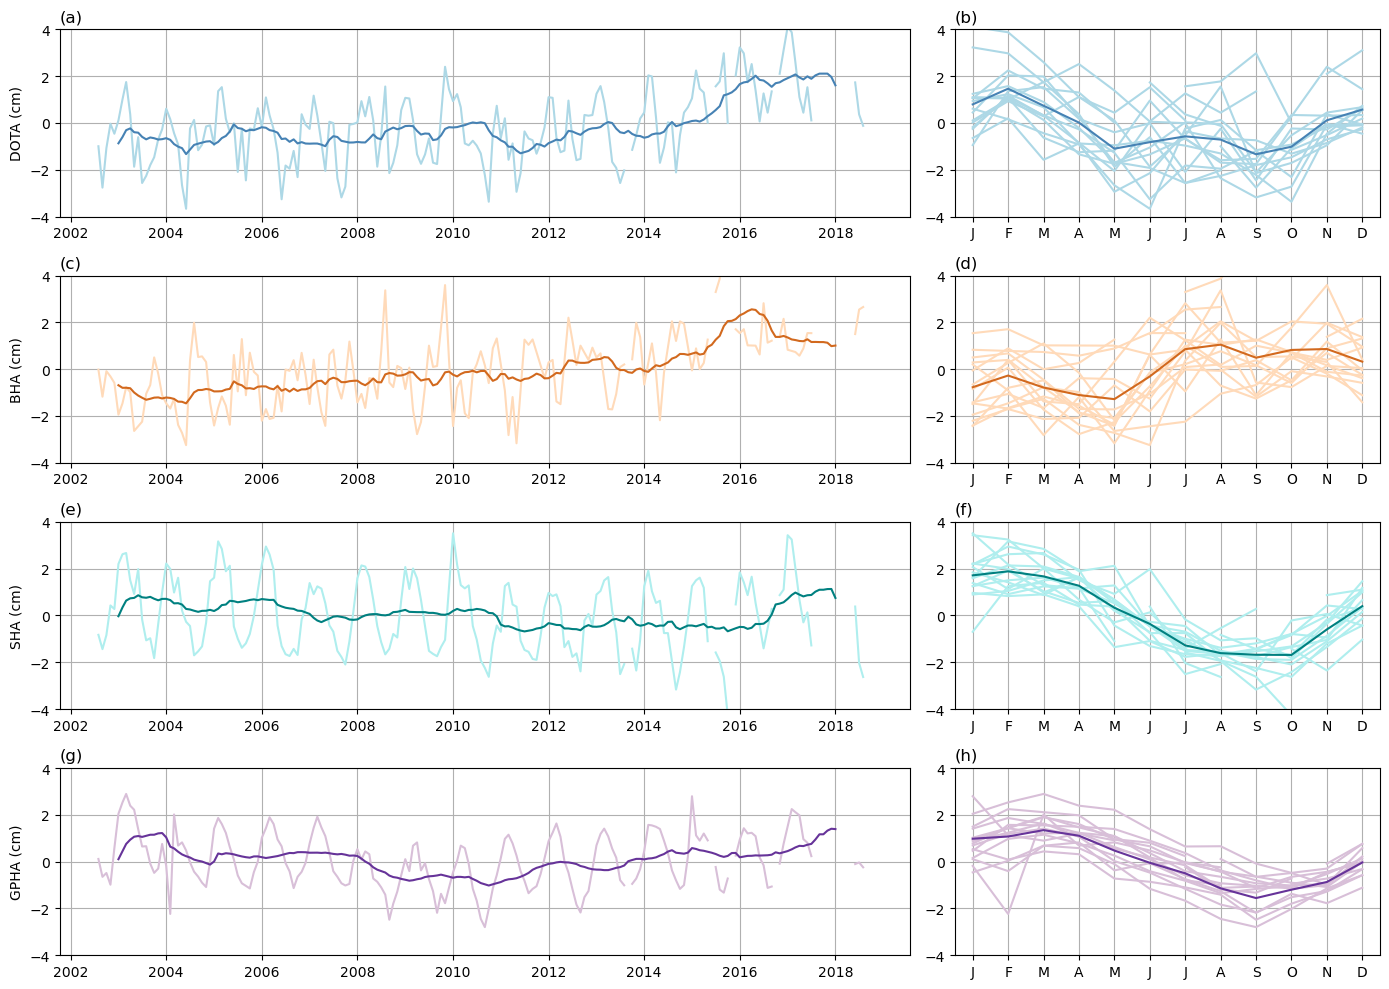

In [37]:
fig, axs = timeseries_with_cmt(ds)


In [38]:
fig.savefig('plots/figure4.png',dpi=200,transparent=True,bbox_inches='tight')
